In [7]:
#Common Variables
PROCESSEDBODY = "output/processed_body.csv"
PROCESSEDOUTPUT = "output/processed_final.csv"

In [8]:
import os
import string
import pandas as pd
import numpy as np
import gensim
import unicodedata
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import json
import re
import html
import warnings
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [9]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [10]:
stemmer = PorterStemmer()
pyLDAvis.enable_notebook() 
current_dir = os.getcwd() + '/output'
coherence_scores = []

In [11]:
CUSTOM_STOP_WORDS = "stopwords.txt"
stop_words_set = set()
stop_words = set(stopwords.words('english'))
for word in stop_words:
    if('\'' in word):
        stop_words_set.add(word.strip().replace('\'', ''))
    stop_words_set.add(word)


try:
    with open(CUSTOM_STOP_WORDS, 'r') as f:
        words = f.readlines()
        for word in words:
            if('\'' in word):
                stop_words_set.add(word.strip().replace('\'', ''))
            stop_words_set.add(word.strip())
except:
    pass

In [12]:
def preprocess_text(text):
    # remove non ascii
    text = unicodedata.normalize('NFKD', text).encode(
        'ascii', 'ignore').decode('utf-8', 'ignore')
    text = text.lower()
    # unescaping
    text = html.unescape(text)
    text = re.sub(r'<code>(.|\n)*?</code>','', text) # removing <code>...</code>
    text = re.sub(r'<a.*?</a>', '', text)  # removing whole anchor tags
    text = re.sub(r'(<.*?>)', '', text)  # removing html markup
    text = re.sub(r'[^\w\s]', '', text)  # removing punctuation
    text = re.sub(r'[\d]', '', text)  # removing digits
    # remove stopwords
    tokenized = []
    for word in text.split():
        if word in stop_words_set:
            continue
        tokenized.append(word)
        
    for i in range(len(tokenized)):
        word = tokenized[i]
        word = WordNetLemmatizer().lemmatize(word, pos='v')
        tokenized[i] = stemmer.stem(word)
    return tokenized

In [13]:
df=pd.read_csv(PROCESSEDBODY)
df['preprocessed'] = ""
for i in range(len(df)):
    df['preprocessed'].iloc[i] = preprocess_text(df.raw.iloc[i])
df.to_csv(PROCESSEDOUTPUT)
df

,id,qa,raw,preprocessed
0,1496,q,What are the preferred versions of Vim and Ema...,"[prefer, version, vim, emac, mac, os, x, graph..."
1,2898,q,Text Editor For Linux (Besides Vi)? <p>Let me ...,"[text, editor, linux, vi, prefac, question, te..."
2,10475,q,Touch Typing Software recommendations <p>Since...,"[touch, type, softwar, recommend, keyboard, in..."
3,12009,q,Piping password to smbpasswd <p>How can I pipe...,"[pip, password, smbpasswd, pipe, password, smb..."
4,12492,q,Pretty printing XML files on Emacs <p>I use em...,"[pretti, print, xml, file, emac, emac, edit, x..."
...,...,...,...,...
70241,63992902,a,<p>I think at this point you should just make ...,"[point, custom, crossvalid, loop, extra, flexi..."
70242,63994413,a,<p>For more flexibility you can use a simple l...,"[flexibl, simpl, load, function, file, kera, g..."
70243,63996947,a,<p>That is because of the type mismatch. Both ...,"[mismatch, regular, python, list, multipli, fl..."
70244,63996893,a,<p>This can probably somewhat simplified by us...,"[simplifi, auxiliari, function, requir, regex,..."


In [14]:
def create_dir(parent_dir, dir_name):
    temp = os.path.join(parent_dir,dir_name)
    try:  
        os.mkdir(temp)  
    except OSError as error:  
        
        pass
    return temp

100%|██████████| 30/30 [26:00<00:00, 52.00s/it]


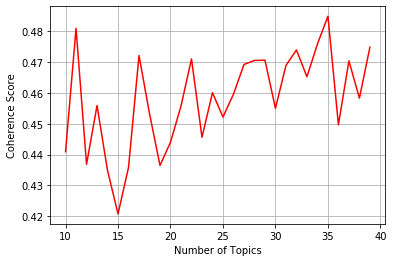

In [15]:
# finding out optimum topic number
data = df['preprocessed']
dictionary = gensim.corpora.Dictionary(data)
corpus = [dictionary.doc2bow(doc) for doc in data]
coherence_scores = []
for num_topics in tqdm(range(10,40)):
    lda = LdaModel(corpus=corpus, num_topics=num_topics,id2word=dictionary, alpha=50/num_topics)
    coherenceModel = CoherenceModel(model=lda, texts=data, dictionary=dictionary, coherence='c_v')
    score = coherenceModel.get_coherence()
    coherence_scores.append([num_topics,score])
# save scores as csv
ch_df = pd.DataFrame(coherence_scores,columns=['Num Topic','Score'])
ch_df.to_csv('output/Coherence_Scores.csv')
# plot
plt.xlabel('Number of Topics') 
plt.ylabel('Coherence Score') 
x = []
y = []
for score in coherence_scores:
    x.append(score[0])
    y.append(score[1])
plt.plot(x,y,c='r')
plt.gca().set_aspect('auto')
plt.grid()
plt.savefig('output/scores.png', dpi=500)
plt.show()

In [16]:
res_dir = create_dir(current_dir, 'Topic Modeling Results')
data = df['preprocessed']
data

0        [prefer, version, vim, emac, mac, os, x, graph...
1        [text, editor, linux, vi, prefac, question, te...
2        [touch, type, softwar, recommend, keyboard, in...
3        [pip, password, smbpasswd, pipe, password, smb...
4        [pretti, print, xml, file, emac, emac, edit, x...
                               ...                        
70241    [point, custom, crossvalid, loop, extra, flexi...
70242    [flexibl, simpl, load, function, file, kera, g...
70243    [mismatch, regular, python, list, multipli, fl...
70244    [simplifi, auxiliari, function, requir, regex,...
70245    [fix, imbal, dataset, realiz, chang, depth, gi...
Name: preprocessed, Length: 70246, dtype: object

In [17]:
dictionary = gensim.corpora.Dictionary(data)

dictionary

In [18]:
corpus = [dictionary.doc2bow(doc) for doc in data]
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 4),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 4),
  (19, 1)],
 [(3, 1),
  (6, 1),
  (18, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 3),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1)],
 [(13, 3),
  (29, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 2),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 3),
  (66, 3),
  (67, 1)],
 [(68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 1), (74, 2)],
 [(3, 1),
  (4, 2),
  (27, 1),
  (32, 1),
  (44, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 4),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),

In [19]:
# create folder for topic number 11 and 32
NUM_TOPICS = 11
    # [,9,14,18,20,22,25,27,28]

topic_dir = create_dir(res_dir, f'{NUM_TOPICS} Topics')
if os.path.isfile(os.path.join(topic_dir, 'lda.pkl')):
    lda = pickle.load(open(os.path.join(topic_dir, 'lda.pkl'), "rb"))
else:
    lda = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, alpha=50/NUM_TOPICS)
    # save the model as pickle
    pickle.dump(lda, open(os.path.join(topic_dir, 'lda.pkl'), "wb"))

topics = [[(word, word_prob) for word, word_prob in lda.show_topic(n, topn=30)] for n in range(lda.num_topics)]
print(topics)

# term-topic matrix
topics_df = pd.DataFrame([[f'{word} {round(word_prob,4)}' for word, word_prob in topic]
                      for topic in topics], columns=[
f'Term {i}' for i in range(1, 31)], index=[f'Topic {n}' for n in range(lda.num_topics)]).T

topics_df.to_csv(os.path.join(topic_dir, 'term x topic.csv'))

# topic words
topic_words_dir = create_dir(topic_dir, 'TopicWords')
for n in range(NUM_TOPICS):
    topic_words_df = pd.DataFrame(
        [[word_prob, word]for word, word_prob in topics[n]], columns=['Prob', 'Word'])

    topic_words_df.to_csv(os.path.join(topic_words_dir, f'{n}.csv'))

[[('class', 0.016632978), ('test', 0.01027521), ('valu', 0.010001033), ('case', 0.009758081), ('function', 0.0091570215), ('output', 0.009075477), ('code', 0.008326996), ('method', 0.0075582904), ('train', 0.0072659696), ('problem', 0.0070785913), ('model', 0.006969034), ('return', 0.005400115), ('predict', 0.0053776545), ('number', 0.005206263), ('file', 0.0051886933), ('input', 0.0048868908), ('result', 0.0048805918), ('run', 0.0048216963), ('paramet', 0.004685892), ('gener', 0.004594325), ('error', 0.004558407), ('featur', 0.004360931), ('time', 0.0043525817), ('variabl', 0.004314558), ('element', 0.004190676), ('pass', 0.004184475), ('fit', 0.0041696965), ('default', 0.0040622363), ('chang', 0.003951756), ('note', 0.0038475615)], [('model', 0.011053633), ('code', 0.010722135), ('predict', 0.009750352), ('case', 0.008503992), ('function', 0.00823668), ('class', 0.007869043), ('problem', 0.007623885), ('test', 0.0072722496), ('train', 0.006966275), ('method', 0.0065661035), ('return'

In [29]:
# topic words
topic_words_dir = create_dir(topic_dir, 'TopicWords')
for n in range(NUM_TOPICS):
    topic_words_df = pd.DataFrame(
        [[word_prob, word]for word, word_prob in topics[n]], columns=['Prob', 'Word'])

    topic_words_df.to_csv(os.path.join(topic_words_dir, f'{n}.csv'))

# post to dominant topic
corpus_topic_df = pd.DataFrame()
corpus_topic_df['link'] = df.id
corpus_topic_df['qa'] = df.qa

topic_model_results = lda[corpus]
corpus_topics = [sorted(doc, key=lambda x: -x[1])[0]
                 for doc in topic_model_results]

corpus_topic_df['Dominant Topic'] = [item[0] for item in corpus_topics]
corpus_topic_df['Correlation'] = [item[1] for item in corpus_topics]

corpus_topic_df.to_csv(os.path.join(topic_dir, 'postToTopic.csv'))


In [30]:
topic_to_post_dir = create_dir(topic_dir, 'TopicToPost')
for i in range(NUM_TOPICS):
    temp = create_dir(topic_to_post_dir, str(i))
    temp_q_df = corpus_topic_df.loc[corpus_topic_df['Dominant Topic'] == i]
    temp_q_df = temp_q_df.loc[temp_q_df['qa'] == 'q']
    temp_a_df = corpus_topic_df.loc[corpus_topic_df['Dominant Topic'] == i]
    temp_a_df = temp_a_df.loc[temp_a_df['qa'] == 'a']
    temp_q_df.drop(columns=['Dominant Topic','qa']).to_csv(
        os.path.join(temp, 'Questions.csv'), index=False)
    # temp_q_df.drop(columns=['Dominant Topic','qa']).to_excel(
    #     os.path.join(temp, 'Questions.xlsx'), index=False)
    temp_a_df.drop(columns=['Dominant Topic','qa']).to_csv(
        os.path.join(temp, 'Answers.csv'), index=False)
    # temp_a_df.drop(columns=['Dominant Topic','qa']).to_excel(
    #     os.path.join(temp, 'Answers.xlsx'), index=False)

In [31]:
# post count under any topic
topic_post_cnt_df = corpus_topic_df.groupby('Dominant Topic').agg(
    Document_Count=('Dominant Topic', np.size),
    Percentage=('Dominant Topic', np.size)).reset_index()

topic_post_cnt_df['Percentage'] = topic_post_cnt_df['Percentage'].apply(
    lambda x: round((x*100) / len(corpus), 2))

topic_post_cnt_df.to_csv(os.path.join(topic_dir, 'postPerTopic.csv'))